In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

import polars as pl
import numpy as np

from adex.models import Condition, ConditionDataLoader, ConditionSequencingTissueDataLoader, \
    ConditionSequencingDataLoader, SequencingTechnique, TissueEnum, METADATA_COLUMNS, FileDataLoader, DataLoader
from adex.helpers import get_pre_processed_dataset, run_ml_model
from adex.models import DATASET_INFO_COLUMNS
from sklearn import model_selection

data_path = "../data/adex-database/samples"
metadata_path = "../data/adex-database/metadata.csv"
datasets_info_path = "../data/adex-database/datasets_info.csv"
results_path = "../results"

# Prepare Data

In [2]:
top10_de_genes_ra_GSE89408 = (
    pl
    .read_csv(f"../data/ml/GSE89408_top_de_train_genes.csv", has_header=True)
    .to_series()
    .to_list()
)
len(top10_de_genes_ra_GSE89408)

10

In [3]:
de_GSE89408 = (
    get_pre_processed_dataset(
        data_loader=FileDataLoader(
            condition=Condition.RA,
            file_name="GSE89408.tsv.parquet",
            genes=top10_de_genes_ra_GSE89408
        ),
        data_path=data_path,
        metadata_path=metadata_path,
        datasets_info_path=datasets_info_path,
        return_metadata=True
    ).fill_null(value=0)
    .drop(filter(lambda item: item != 'Condition',METADATA_COLUMNS)) # We need only the condition from Metadata  
    .drop(DATASET_INFO_COLUMNS)
    .with_columns(
        pl.col("Condition")
            .map_elements(lambda x: 0 if x == "Healthy" else 1, return_dtype=pl.Int8)
            .alias("class_label")
    )
    .drop("Condition")
).sort("Sample")  # Remove randomness at this point 
de_GSE89408

Sample,HSPE1-MOB4,AC017083.2,U62317.1,AC020909.4,HOXC-AS1,AL139099.1,AC211429.1,AC025423.4,AC025259.1,AC068631.2,class_label
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i8
"""GSM2370970""",0.0,0.0,0.0,0.0,7.776255,0.0,6.472111,0.0,0.0,5.322358,0
"""GSM2370971""",6.562024,7.938222,0.0,5.274107,5.827561,7.078922,3.094096,7.707919,6.073492,1.326442,0
"""GSM2370972""",0.0,7.53651,0.858757,3.808962,5.136107,0.0,3.056805,6.148911,0.0,2.341239,0
"""GSM2370973""",0.0,0.0,1.069102,0.0,5.965672,3.11884,5.131011,5.776321,0.0,0.0,0
"""GSM2370974""",0.0,5.758763,0.0,3.860753,6.059763,0.0,4.70726,4.476259,0.0,1.963042,0
…,…,…,…,…,…,…,…,…,…,…,…
"""GSM2371183""",6.852084,7.564782,2.794609,4.979133,4.167273,8.181333,2.606461,7.378751,5.721076,6.175148,1
"""GSM2371184""",8.125291,8.341194,3.255327,7.544912,1.352949,10.372098,2.288607,7.99071,4.777353,7.60949,1
"""GSM2371185""",6.937231,7.450259,3.103816,6.416332,3.772043,9.312345,3.772043,8.041741,5.047704,5.154133,1


In [4]:
de_GSE89408.select(pl.col("class_label").value_counts()) # Imbalanced data between the two classes

class_label
struct[2]
"{0,28}"
"{1,152}"


In [5]:
x_df = (
        de_GSE89408.select([
            pl.all().exclude("Sample", "class_label"),
        ]).to_pandas()
 )
x_df

,HSPE1-MOB4,AC017083.2,U62317.1,AC020909.4,HOXC-AS1,AL139099.1,AC211429.1,AC025423.4,AC025259.1,AC068631.2
0,0.000000,0.000000,0.000000,0.000000,7.776255,0.000000,6.472111,0.000000,0.000000,5.322358
1,6.562024,7.938222,0.000000,5.274107,5.827561,7.078922,3.094096,7.707919,6.073492,1.326442
2,0.000000,7.536510,0.858757,3.808962,5.136107,0.000000,3.056805,6.148911,0.000000,2.341239
3,0.000000,0.000000,1.069102,0.000000,5.965672,3.118840,5.131011,5.776321,0.000000,0.000000
4,0.000000,5.758763,0.000000,3.860753,6.059763,0.000000,4.707260,4.476259,0.000000,1.963042
...,...,...,...,...,...,...,...,...,...,...
175,6.852084,7.564782,2.794609,4.979133,4.167273,8.181333,2.606461,7.378751,5.721076,6.175148
176,8.125291,8.341194,3.255327,7.544912,1.352949,10.372098,2.288607,7.990710,4.777353,7.609490
177,6.937231,7.450259,3.103816,6.416332,3.772043,9.312345,3.772043,8.041741,5.047704,5.154133
178,6.764702,7.930536,2.795792,6.813169,3.197420,10.422702,0.000000,7.969548,5.986713,6.608690


In [6]:
y_df = de_GSE89408.select(pl.col("class_label").alias("y")).to_pandas()
y_df

,y
0,0
1,0
2,0
3,0
4,0
...,...
175,1
176,1
177,1
178,1


In [7]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(
    x_df, y_df, 
    train_size=0.7, 
    random_state=42,  # Ensure a reproducible split 
    shuffle=True, 
    stratify=y_df  # solve the class imbalance issue 
)

In [8]:
x_train

,HSPE1-MOB4,AC017083.2,U62317.1,AC020909.4,HOXC-AS1,AL139099.1,AC211429.1,AC025423.4,AC025259.1,AC068631.2
13,0.000000,0.000000,1.864341,0.000000,6.532242,0.000000,5.213109,4.348193,0.000000,3.828335
73,6.102829,7.122238,5.518350,6.487267,2.267737,10.635017,2.749214,6.921170,6.062215,7.227001
4,0.000000,5.758763,0.000000,3.860753,6.059763,0.000000,4.707260,4.476259,0.000000,1.963042
5,0.000000,5.965939,3.491997,3.617796,4.619271,7.339339,3.031357,7.195406,0.000000,0.000000
57,0.000000,5.156864,3.369568,5.534341,3.544659,9.256971,0.000000,6.887080,3.841646,0.000000
...,...,...,...,...,...,...,...,...,...,...
53,6.492915,7.649072,4.026287,6.189286,0.925741,6.324991,2.677611,7.152249,3.321436,6.967549
64,5.741325,7.112296,3.523430,5.764730,3.820045,9.004779,1.857876,7.582939,4.857842,5.483675
176,8.125291,8.341194,3.255327,7.544912,1.352949,10.372098,2.288607,7.990710,4.777353,7.609490
89,5.833912,7.224499,6.023392,6.062321,0.918027,9.491333,3.306743,8.236785,5.788198,6.887744


In [9]:
y_train

,y
13,0
73,1
4,0
5,0
57,1
...,...
53,1
64,1
176,1
89,1


In [10]:
y_train.value_counts()

y
1    106
0     19
Name: count, dtype: int64

In [11]:
x_test

,HSPE1-MOB4,AC017083.2,U62317.1,AC020909.4,HOXC-AS1,AL139099.1,AC211429.1,AC025423.4,AC025259.1,AC068631.2
18,4.951320,7.372085,1.413181,5.412135,4.331076,8.564358,1.805233,6.437239,4.206642,5.692894
98,0.000000,8.311990,5.039403,2.618922,0.000000,7.929231,4.286473,6.781749,5.287529,4.946210
166,6.744603,7.457176,4.546265,5.757994,3.763433,8.646634,2.376680,8.160634,4.151664,6.334043
140,5.722857,0.000000,3.368290,6.590038,2.038738,9.799556,0.000000,6.408358,5.778389,4.693256
29,6.737572,7.280784,3.565866,5.471475,2.206040,6.973673,2.206040,7.305715,5.316553,5.856029
90,0.000000,7.198596,2.823497,5.528463,2.417373,8.490438,1.850073,6.763955,4.661924,5.682767
162,7.737913,8.126394,3.730405,7.111682,3.238416,9.872784,1.722972,7.445874,5.380375,6.923948
105,2.322852,5.615841,4.859096,5.524691,0.000000,8.922993,3.001010,5.171047,0.000000,3.460481
74,6.407781,0.000000,3.025182,4.649640,1.477789,0.000000,0.000000,0.000000,5.838809,6.345800
45,5.766810,7.258533,4.430082,4.124789,3.205202,9.390506,0.000000,6.697451,6.578365,5.871831


In [12]:
y_test

,y
18,0
98,1
166,1
140,1
29,1
90,1
162,1
105,1
74,1
45,1


In [13]:
y_test.value_counts()

y
1    46
0     9
Name: count, dtype: int64

# Logistic Regression 

Cross Validation Scores (cv=4): 0.96875,1.0,0.9354838709677419,0.9032258064516129
Cross Validation gives 0.95 accuracy with a standard deviation of 0.04

Metrics on the Test Set:

        Accuracy: 0.9636363636363636
        Precision: 0.9583333333333334
        Recall: 1.0
        f1: 0.9787234042553191
    


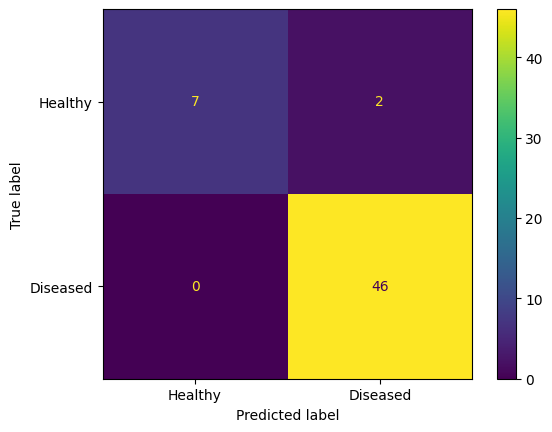

In [14]:
logistic_model, _ = run_ml_model(
    classifier=LogisticRegression(solver='liblinear', random_state=0),
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
)

In [15]:
logistic_model.intercept_

array([0.04344528])

In [16]:
logistic_model.coef_

array([[ 0.47224376, -0.28631353,  0.37334052,  0.35665901, -1.17207877,
         0.11867795, -0.43851996,  0.52761207, -0.38956601,  0.91810734]])

In [17]:
logistic_model.predict_proba(x_test)

array([[7.67922998e-03, 9.92320770e-01],
       [3.68479063e-03, 9.96315209e-01],
       [1.33545696e-04, 9.99866454e-01],
       [2.57680197e-05, 9.99974232e-01],
       [1.42241334e-04, 9.99857759e-01],
       [4.76689473e-03, 9.95233105e-01],
       [4.06699339e-05, 9.99959330e-01],
       [1.27738949e-04, 9.99872261e-01],
       [4.63297809e-04, 9.99536702e-01],
       [5.34706785e-04, 9.99465293e-01],
       [2.54923610e-06, 9.99997451e-01],
       [5.77534434e-04, 9.99422466e-01],
       [1.76094485e-05, 9.99982391e-01],
       [1.59562933e-06, 9.99998404e-01],
       [1.03510465e-01, 8.96489535e-01],
       [5.52359952e-06, 9.99994476e-01],
       [3.21059478e-04, 9.99678941e-01],
       [9.97908889e-01, 2.09111066e-03],
       [7.64511013e-07, 9.99999235e-01],
       [6.14179936e-05, 9.99938582e-01],
       [2.66115593e-05, 9.99973388e-01],
       [9.38572440e-06, 9.99990614e-01],
       [1.43762883e-02, 9.85623712e-01],
       [7.59313067e-07, 9.99999241e-01],
       [1.696219

# Decision Tree 

Cross Validation Scores (cv=4): 0.9375,0.967741935483871,0.967741935483871,0.9354838709677419
Cross Validation gives 0.95 accuracy with a standard deviation of 0.02

Metrics on the Test Set:

        Accuracy: 0.9272727272727272
        Precision: 0.9375
        Recall: 0.9782608695652174
        f1: 0.9574468085106383
    


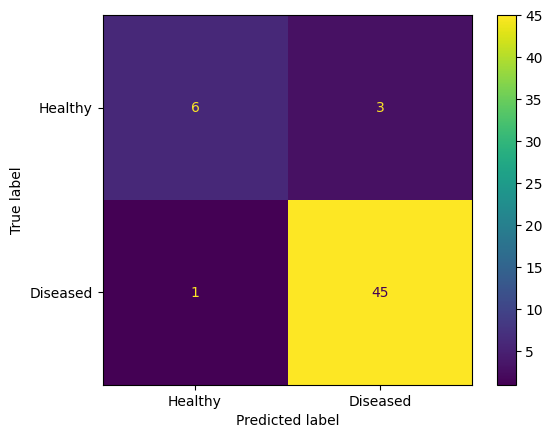

In [18]:
from sklearn import tree

tree_model, _ = run_ml_model(
    classifier=tree.DecisionTreeClassifier(),
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
)

[Text(0.4444444444444444, 0.9, 'x[4] <= 4.54\ngini = 0.258\nsamples = 125\nvalue = [19, 106]'),
 Text(0.2222222222222222, 0.7, 'x[7] <= 2.865\ngini = 0.019\nsamples = 103\nvalue = [1.0, 102.0]'),
 Text(0.1111111111111111, 0.5, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.3333333333333333, 0.5, 'gini = 0.0\nsamples = 102\nvalue = [0, 102]'),
 Text(0.6666666666666666, 0.7, 'x[9] <= 3.89\ngini = 0.298\nsamples = 22\nvalue = [18, 4]'),
 Text(0.5555555555555556, 0.5, 'gini = 0.0\nsamples = 14\nvalue = [14, 0]'),
 Text(0.7777777777777778, 0.5, 'x[0] <= 2.197\ngini = 0.5\nsamples = 8\nvalue = [4, 4]'),
 Text(0.6666666666666666, 0.3, 'x[2] <= 1.998\ngini = 0.32\nsamples = 5\nvalue = [4, 1]'),
 Text(0.5555555555555556, 0.1, 'gini = 0.0\nsamples = 4\nvalue = [4, 0]'),
 Text(0.7777777777777778, 0.1, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.8888888888888888, 0.3, 'gini = 0.0\nsamples = 3\nvalue = [0, 3]')]

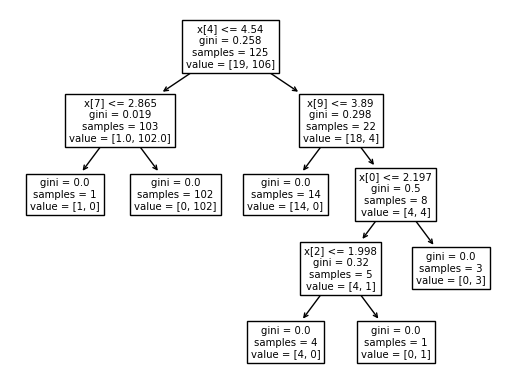

In [19]:
tree.plot_tree(tree_model)

# Gradient boosted Tree

Cross Validation Scores (cv=4): 0.96875,0.967741935483871,0.967741935483871,0.8387096774193549
Cross Validation gives 0.94 accuracy with a standard deviation of 0.06

Metrics on the Test Set:

        Accuracy: 0.9636363636363636
        Precision: 0.9583333333333334
        Recall: 1.0
        f1: 0.9787234042553191
    


(HistGradientBoostingClassifier(),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1], dtype=int8))

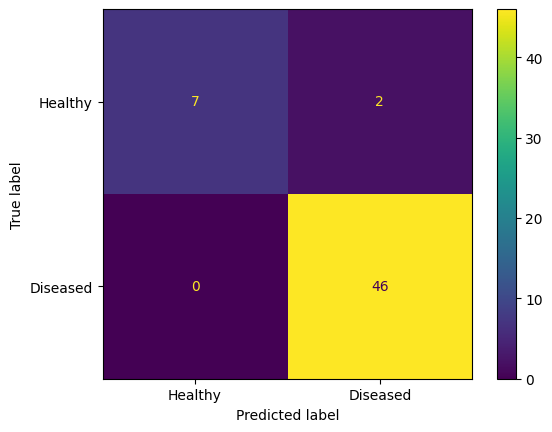

In [20]:
from sklearn.ensemble import HistGradientBoostingClassifier

run_ml_model(
    classifier=HistGradientBoostingClassifier(max_iter=100), 
    x_train=x_train, 
    y_train=y_train, 
    x_test=x_test, 
    y_test=y_test,
)

# Random Forest 

Cross Validation Scores (cv=4): 0.96875,1.0,0.9032258064516129,0.9032258064516129
Cross Validation gives 0.94 accuracy with a standard deviation of 0.04

Metrics on the Test Set:

        Accuracy: 0.9636363636363636
        Precision: 0.9583333333333334
        Recall: 1.0
        f1: 0.9787234042553191
    


(RandomForestClassifier(n_estimators=10),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1], dtype=int8))

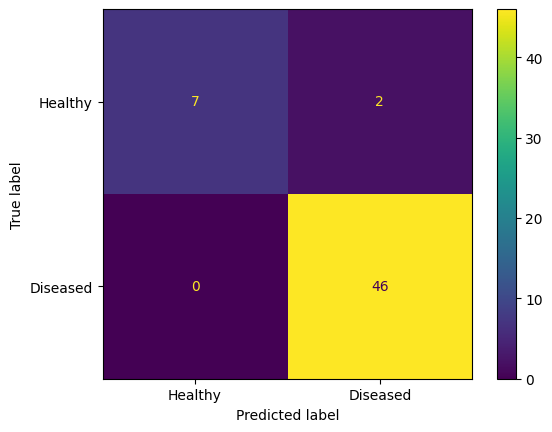

In [21]:
from sklearn.ensemble import RandomForestClassifier

run_ml_model(
    classifier=RandomForestClassifier(n_estimators=10),
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
)

# SVMs

Cross Validation Scores (cv=4): 0.9375,1.0,0.9354838709677419,0.9354838709677419
Cross Validation gives 0.95 accuracy with a standard deviation of 0.03

Metrics on the Test Set:

        Accuracy: 0.9636363636363636
        Precision: 0.9583333333333334
        Recall: 1.0
        f1: 0.9787234042553191
    


(SVC(),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1], dtype=int8))

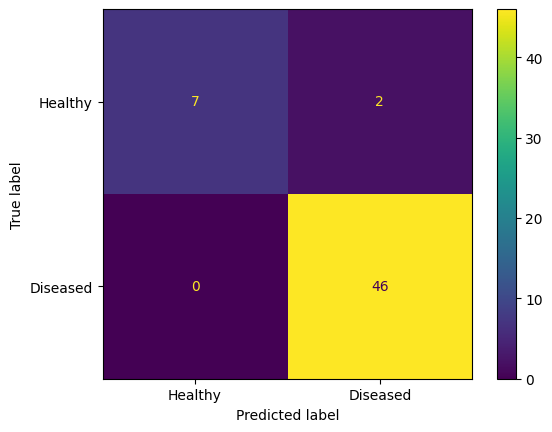

In [22]:
from sklearn import svm

run_ml_model(
    classifier=svm.SVC(),
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
)